# This script handles S2 band normalization

## Imports

In [86]:
import os
import re
import subprocess
from collections import defaultdict
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.warp import reproject, Resampling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob

#import geopandas as gpd
import pandas as pd

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import utils.basics as bsc 
import utils.plotting as pt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## load the data

In [87]:
# PATHS
S2_stacked_1 = "../data/02_processed/S2_Stacked_Site_1.tif"
S2_stacked_2 = "../data/02_processed/S2_Stacked_Site_2.tif"
ALS_PATH1_RES = "../data/02_processed/ALS_resampled_site1.tif"
ALS_PATH2_RES = "../data/02_processed/ALS_resampled_site2.tif"
ALS_PATH1_P = '../data/02_processed/ALS_GT01_2024_processed.tif'
ALS_PATH2_P = '../data/02_processed/ALS_GT02_2024_processed.tif'

In [88]:
# Load S2 and merged ALS data for both sites and combine them in an array
s2_np, als_np, band_names = bsc.load_rasters(S2_stacked_1, ALS_PATH1_RES)
s2_np2, als_np2, band_names = bsc.load_rasters(S2_stacked_2, ALS_PATH2_RES)

✅ Loaded S2: (13, 846, 1241), ALS: (846, 1241)
S2_Stacked_Site_1.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre
  Band names: ('BLU', 'BNR', 'EVI', 'GRN', 'NBR', 'NDV', 'NIR', 'RE1', 'RE2', 'RE3', 'RED', 'SW1', 'SW2')

ALS_resampled_site1.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre

✅ Loaded S2: (13, 1002, 815), ALS: (1002, 815)
S2_Stacked_Site_2.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 9.99 x 10.00 metre
  Band names: ('BLU', 'BNR', 'EVI', 'GRN', 'NBR', 'NDV', 'NIR', 'RE1', 'RE2', 'RE3', 'RED', 'SW1', 'SW2')

ALS_resampled_site2.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 9.99 x 10.00 metre



,B1_BLU,B2_BNR,B3_EVI,B4_GRN,B5_NBR,B6_NDV,B7_NIR,B8_RE1,B9_RE2,B10_RE3,B11_RED,B12_SW1,B13_SW2
P0,-9999.00,-9999.00,-26065.0,-9999.0,-9999.00,-9999.0,-9999.00,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
P0.1,-9999.00,-9999.00,-9999.0,-9999.0,-9999.00,-9999.0,-9999.00,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
P25,-9999.00,-9999.00,-9999.0,-9999.0,-9999.00,-9999.0,-9999.00,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
P50,148.00,2177.00,4169.0,288.0,4963.00,7182.0,2413.00,532.0,1725.0,2137.0,159.0,1171.0,453.0
P75,206.00,2944.00,5483.0,404.0,7097.00,8816.0,3074.00,709.0,2156.0,2721.0,229.0,1430.0,580.0
P95,640.00,3887.00,6527.0,920.0,7482.00,9086.0,3904.00,1349.0,3056.0,3587.0,1007.0,2240.0,1515.0
P99.9,1213.12,6001.12,9438.0,1536.0,7957.12,9418.0,5998.12,2097.0,4852.0,5774.0,1906.0,3021.0,2574.0
P100,6898.00,7838.00,25990.0,7487.0,8462.00,9800.0,7261.00,6294.0,6025.0,6981.0,8109.0,5942.0,5956.0
NaN Ratio,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0


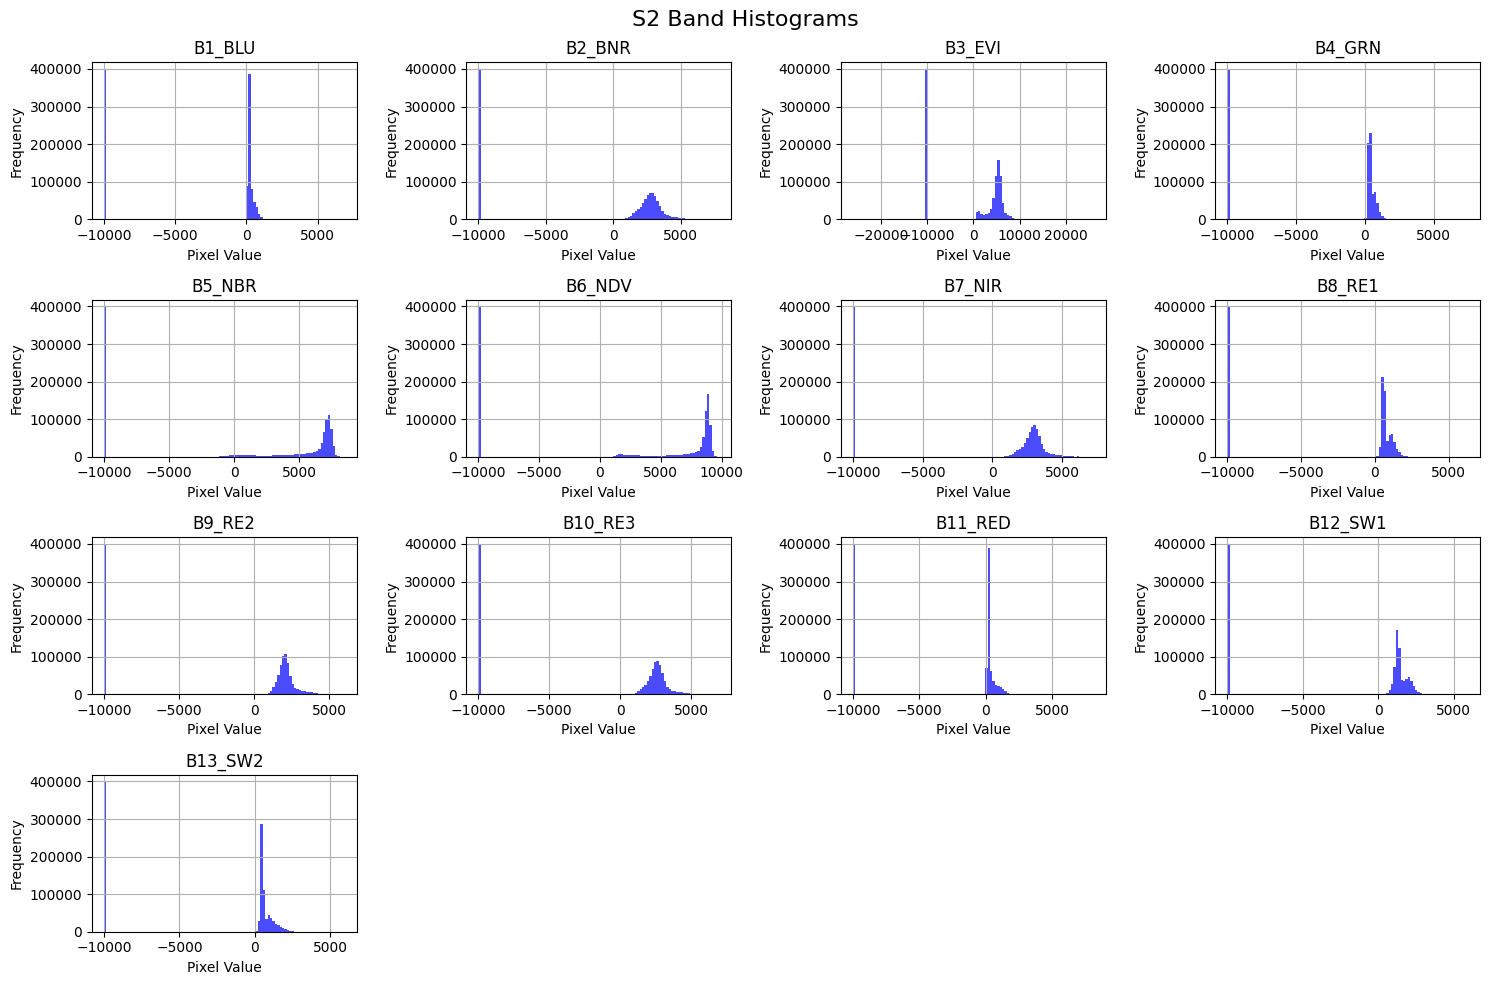

In [89]:
pt.plot_s2_histograms_and_percentiles(s2_np, num_bands=13, band_names=band_names)

⚡️ we observe: many missing values (-9999.0) and real values are just within a small range. --> we need to normalize! 

## Normalize S2 channels

In [90]:
def normalize_s2_data(s2_data, min_percentile=0.1, max_percentile=99.9):
    """
    Normalize S2 data to the range [0, 1] for each band.

    Parameters:
    - s2_data: numpy array of S2 data (bands, height, width)

    Returns:
    - normalized_s2: numpy array of normalized S2 data
    """
    
    # Ensure S2 data is non-negative
    s2_data[s2_data < 0] = np.nan

    normalized_s2 = np.zeros_like(s2_data, dtype=np.float32)
    
    for i in range(s2_data.shape[0]):
        band_data = s2_data[i]
        band_min = np.nanpercentile(band_data, min_percentile)
        band_max = np.nanpercentile(band_data, max_percentile)
        # clip values to avoid extreme outliers
        band_data = np.clip(band_data, band_min, band_max)
        # Avoid division by zero
        if band_max - band_min > 0:
            normalized_s2[i] = (band_data - band_min) / (band_max - band_min)
        else:
            normalized_s2[i] = np.nan  # If all values are the same, set to 0

    return normalized_s2

In [122]:
s2_1n = normalize_s2_data(s2_np)
s2_2n = normalize_s2_data(s2_np2)

## now histograms should look much better.

,B1_BLU,B2_BNR,B3_EVI,B4_GRN,B5_NBR,B6_NDV,B7_NIR,B8_RE1,B9_RE2,B10_RE3,B11_RED,B12_SW1,B13_SW2
P0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
P0.1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
P25,0.07,0.34,0.45,0.13,0.75,0.82,0.35,0.17,0.29,0.32,0.06,0.33,0.14
P50,0.10,0.42,0.53,0.17,0.87,0.92,0.43,0.22,0.35,0.38,0.08,0.38,0.17
P75,0.21,0.49,0.59,0.35,0.91,0.94,0.49,0.41,0.41,0.45,0.18,0.54,0.32
P95,0.53,0.67,0.71,0.61,0.94,0.96,0.66,0.64,0.65,0.64,0.59,0.74,0.63
P99.9,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
P100,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
NaN Ratio,0.38,0.38,0.38,0.38,0.40,0.38,0.38,0.38,0.38,0.38,0.38,0.38,0.38


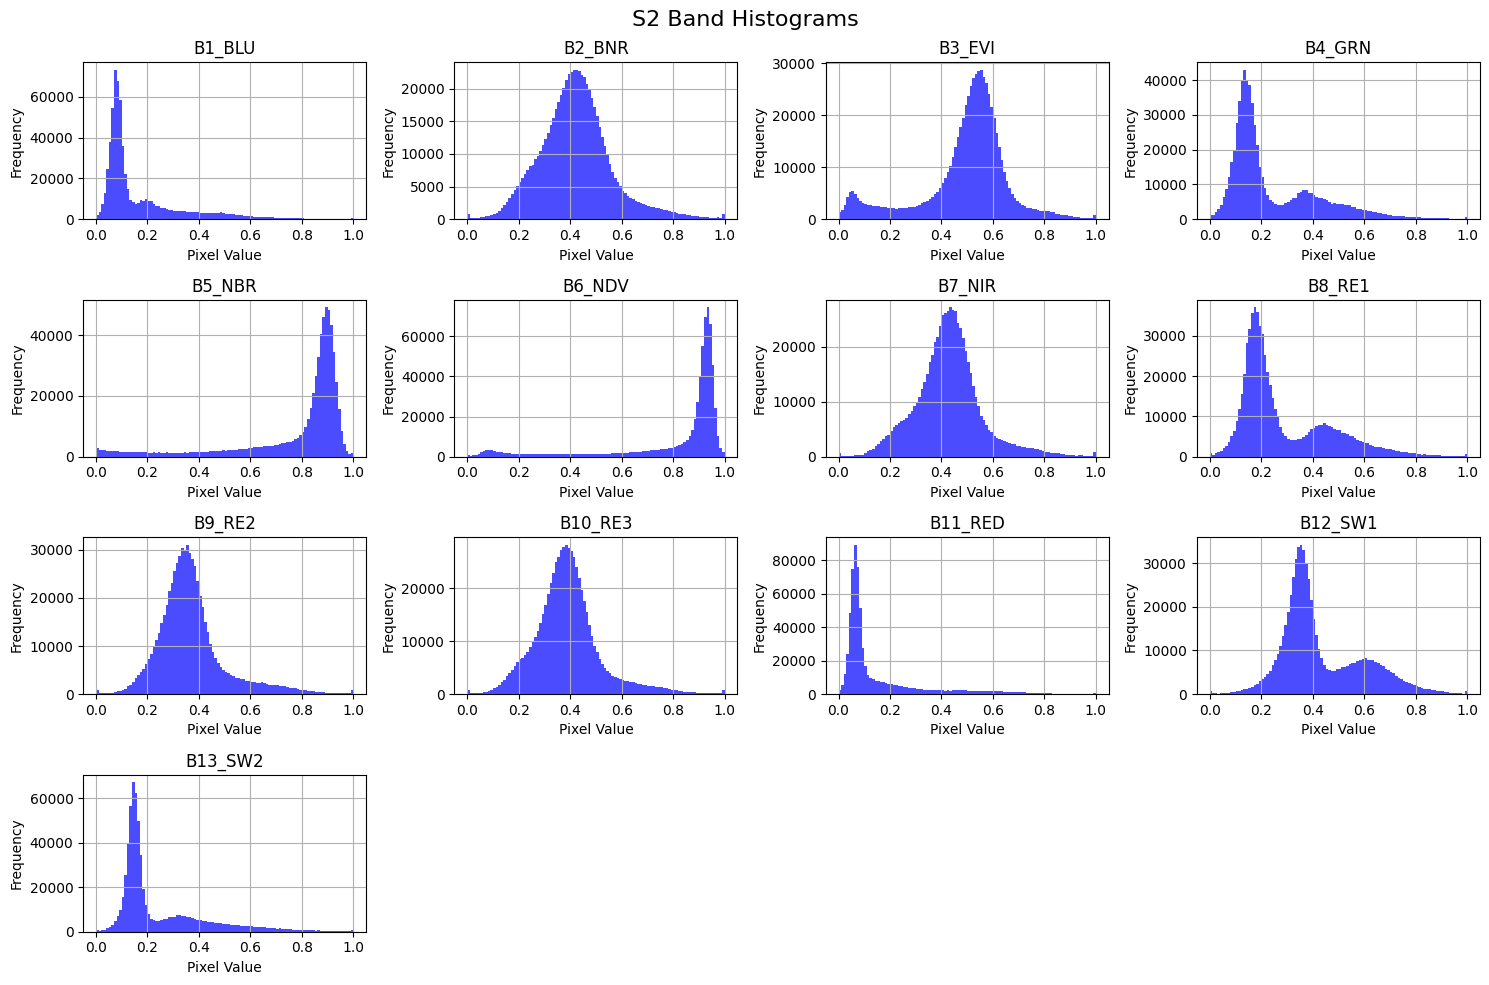

In [123]:
pt.plot_s2_histograms_and_percentiles(s2_1n, num_bands=13, band_names=band_names)

,B1_BLU,B2_BNR,B3_EVI,B4_GRN,B5_NBR,B6_NDV,B7_NIR,B8_RE1,B9_RE2,B10_RE3,B11_RED,B12_SW1,B13_SW2
P0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
P0.1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
P25,0.05,0.29,0.27,0.10,0.40,0.43,0.30,0.14,0.27,0.27,0.05,0.22,0.10
P50,0.08,0.39,0.54,0.15,0.78,0.89,0.41,0.21,0.34,0.36,0.08,0.28,0.14
P75,0.29,0.49,0.63,0.39,0.84,0.94,0.50,0.49,0.41,0.44,0.37,0.54,0.47
P95,0.44,0.65,0.73,0.54,0.89,0.96,0.64,0.68,0.63,0.59,0.65,0.74,0.74
P99.9,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
P100,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
NaN Ratio,0.00,0.00,0.00,0.00,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


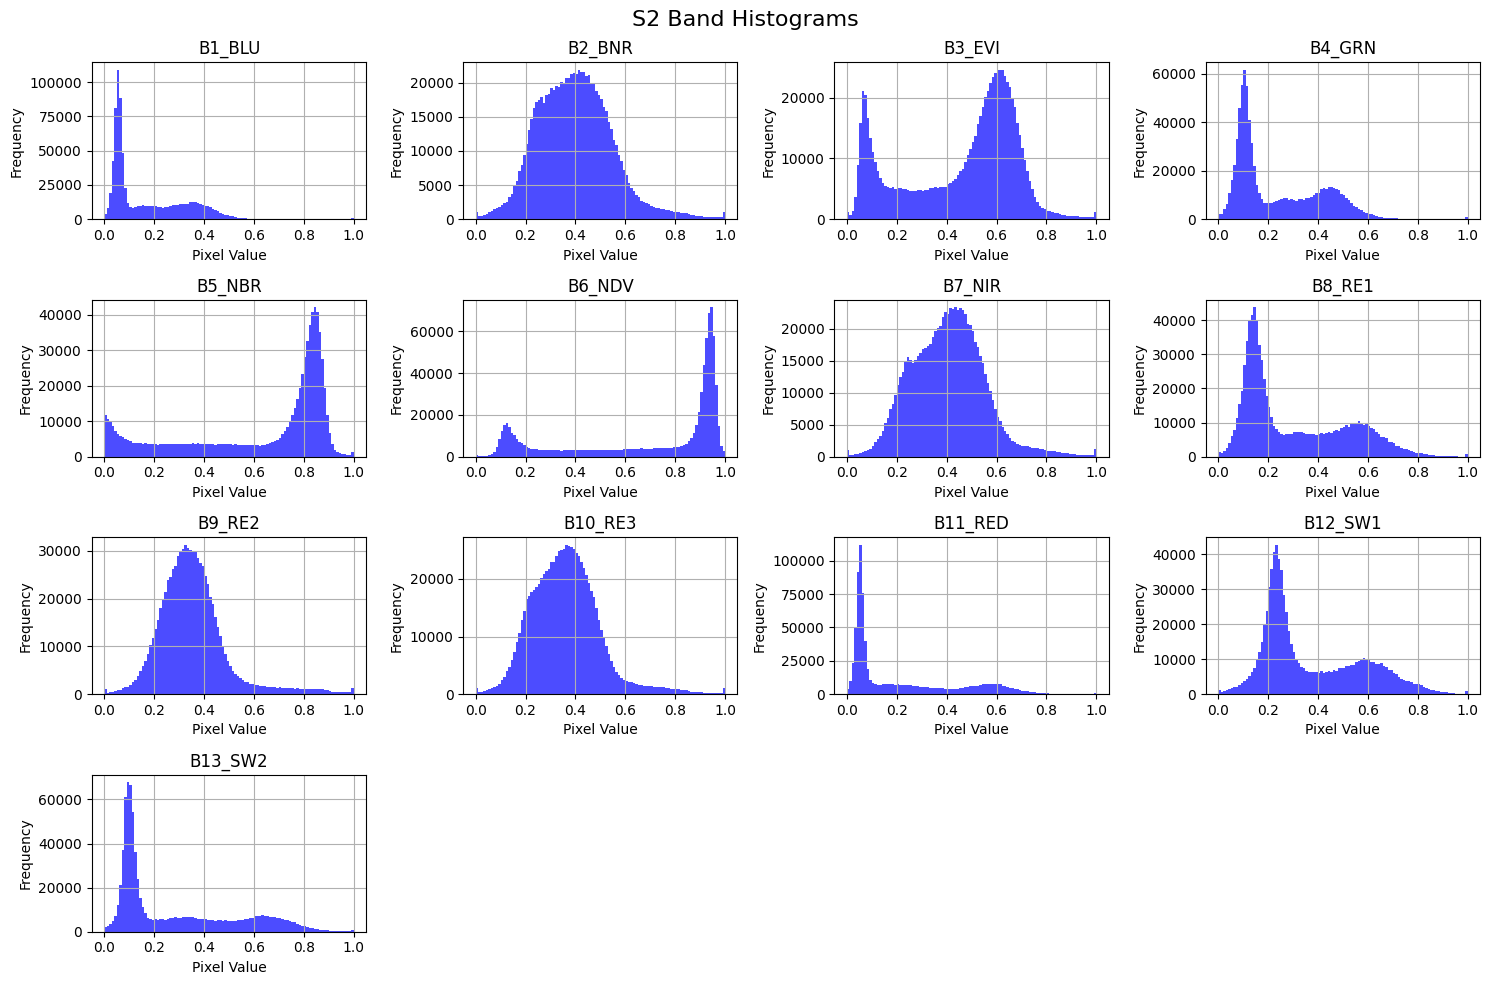

In [78]:
pt.plot_s2_histograms_and_percentiles(s2_2n, num_bands=13, band_names=band_names)

## now lets save the normalized data

In [105]:
# write a function to save the normalized S2 data and keep the metadata of the original S2 data by takting the original path as input
def save_normalized_s2(s2_data, original_path, output_path):
    """
    Save normalized S2 data to a new file while preserving the original metadata.

    Parameters:
    - s2_data: numpy array of normalized S2 data (bands, height, width)
    - original_path: path to the original S2 file
    - output_path: path to save the normalized S2 data
    """
    with rasterio.open(original_path) as src:
        meta = src.meta.copy()
        meta.update({
            'dtype': s2_data.dtype,
            'count': s2_data.shape[0],
            'compress': 'lzw'
        })

        with rasterio.open(output_path, 'w', **meta) as dst:
            dst.write(s2_data.astype('float32'))
            dst.descriptions = src.descriptions
    print(f"✅ Normalized S2 data saved to {output_path}")

In [106]:
S2_stacked_1_normalized = "../data/02_processed/S2_Stacked_Site_1_norm.tif"
S2_stacked_2_normalized = "../data/02_processed/S2_Stacked_Site_2_norm.tif"

In [126]:
save_normalized_s2(s2_1n, S2_stacked_1, S2_stacked_1_normalized)
save_normalized_s2(s2_2n, S2_stacked_2, S2_stacked_2_normalized)

✅ Normalized S2 data saved to ../data/02_processed/S2_Stacked_Site_1_norm.tif
✅ Normalized S2 data saved to ../data/02_processed/S2_Stacked_Site_2_norm.tif


In [ ]:
# lets test it by loading the normalized S2 data and the ALS data again
s2_1n, als_np, band_names = bsc.load_rasters(S2_stacked_1_normalized, ALS_PATH1_RES)

✅ Loaded S2: (13, 846, 1241), ALS: (846, 1241)
S2_Stacked_Site_1_norm.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre
  Band names: ('BLU', 'BNR', 'EVI', 'GRN', 'NBR', 'NDV', 'NIR', 'RE1', 'RE2', 'RE3', 'RED', 'SW1', 'SW2')

ALS_resampled_site1.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre



## lets have a look at the RGB channels

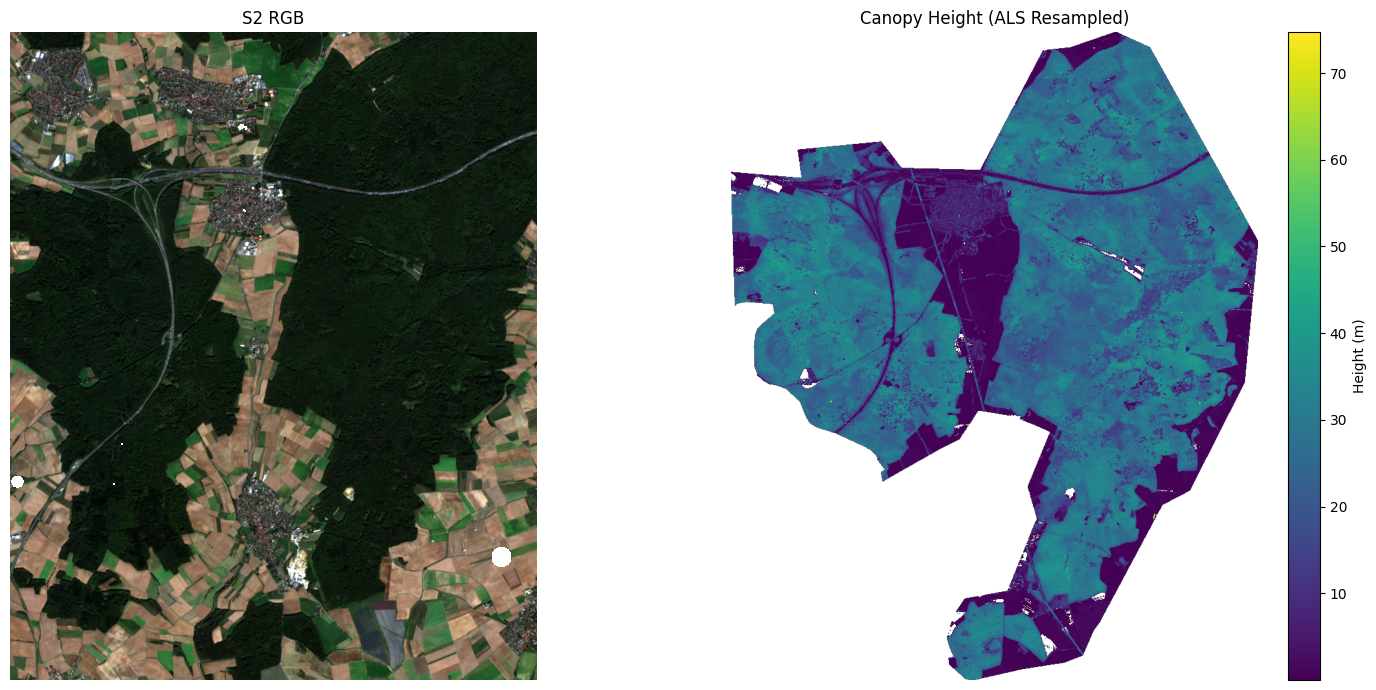

In [130]:
pt.plot_full_image(s2_2n, als_np2)

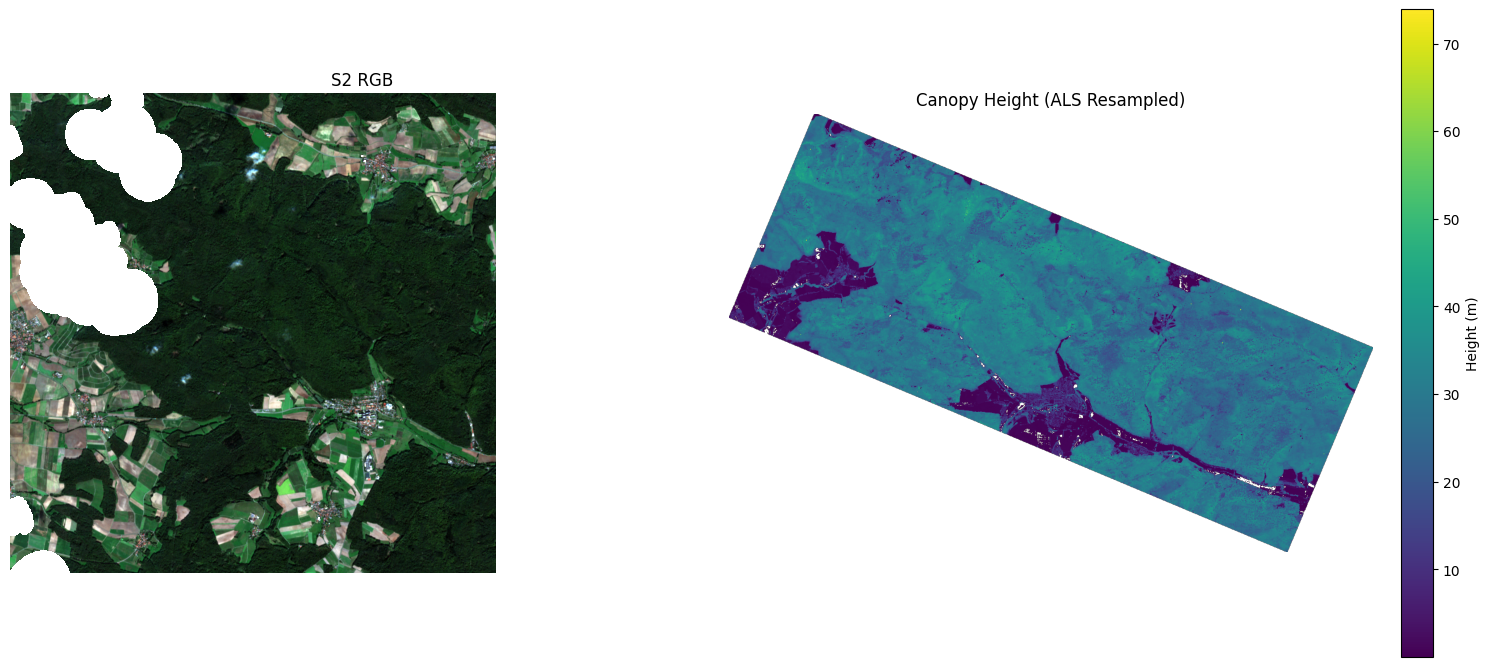

In [129]:
pt.plot_full_image(s2_1n, als_np)

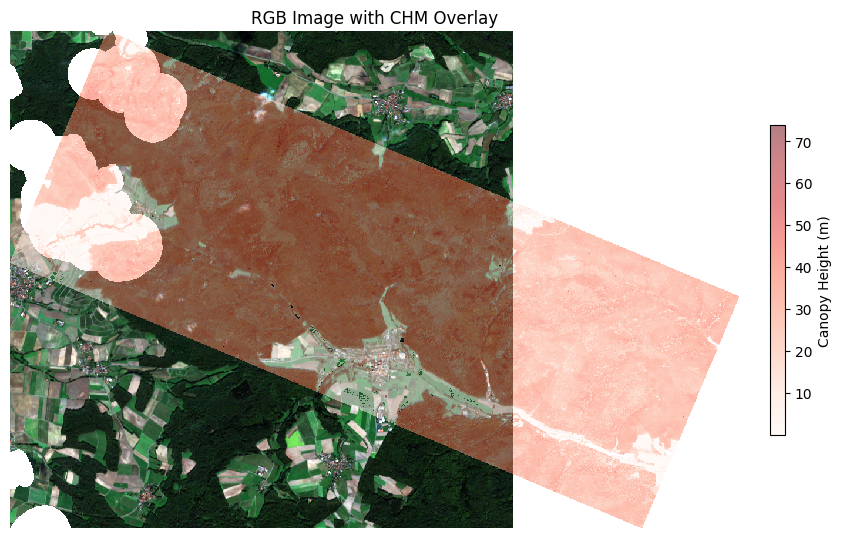

In [131]:
pt.plot_overlay(s2_1n, als_np)

now we're set.